In [5]:
import math
import numpy as np
import matplotlib.pyplot as pyplot

In [6]:
from scipy.stats import norm
from scipy.linalg import solve

In [7]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 160
rcParams['font.size'] = 20
rcParams['font.family'] = 'Arial'

In [8]:
%matplotlib inline

# Symbols

\$T = \$ expiration time \
\$S = \$ stock price \
\$K = \$ strike \
\$r = \$ risk free rate \
\$q = \$ dividend yield \
\$\mu = \$ expected return (constant)\
\$\sigma = \$ volatility (constant)

# zero volatility

\$ \rm{d}S = \mu S \rm{d}t \$ \
\$ S_T = S_0 \rm{e}^{\mu T} \quad\textit{or}\quad \ln{S_t} = \ln{S_0} + \mu T\$

# not zero volatility
\$ \rm{d}S = \mu S \rm{d}t + S\sigma \rm{d}W(t)\$ \
\$ S_T = S_0 \rm{e}^{\big(\mu - \frac{\sigma^2}{2}\big)T  + \sigma\sqrt{T}} \quad\textit{or}\quad \ln{S_t} = \ln{S_0} + {\big(\mu - \frac{\sigma^2}{2}\big)T  + \sigma\sqrt{T}} \$ \
TODO: use dW(t)

In [9]:
# MonteCarlo method prms
nSteps = 10
nPaths = 10000000

In [10]:
S0 = 100.0
K = 110.0
t0 = 0.0
T = 0.2
r = 0.05
q = 0.02
sigma = 0.25

In [11]:
S0 = 102.0
K = 100.0
t0 = 0.0
T = 0.5
r = 0.02
q = 0.0
sigma = 0.2

In [12]:
mu = r - q

# MonteCarlo Mothod

In [13]:
dt = (T - t0) / nSteps
sqrt_dt = np.sqrt(dt)

# random number using N(0, 1)
phi = np.random.normal(size=(nSteps, nPaths)) * sqrt_dt

lnS0 = math.log(S0)
lnST = lnS0

# Evolve paths:
for t in range(nSteps):
    lnST += ((mu - 0.5 * (sigma*sigma)) * dt) + (sigma * phi[t])
ST = np.exp(lnST)

# European Call option:
callPriceMC = math.exp(-r * T) * np.mean(np.maximum(ST - K, 0.0))

# 
callPriceMC

7.291808947687098

# Black–Scholes Formula

In [14]:
dt = T - t0
sqrt_dt = np.sqrt(dt)
sigma_sqrt_dt = sigma * sqrt_dt

d1 = (np.log(S0/K) + (r - q + 0.5 * (sigma * sigma)) * dt) / sigma_sqrt_dt
d2 = d1 - sigma_sqrt_dt

F =  S0 * np.exp((r - q) * dt)

callPriceBS = np.exp(-r * dt) * ((F * norm.cdf(d1)) - (K * norm.cdf(d2)))
    
# 
callPriceBS

7.288151182771624

# PDE

https://notebook.community/numerical-mooc/assignment-bank/Black-Scholes-Equation/Black-Scholes-Equation

# forward-time central-space scheme to solve the Black-Scholes equation for the call option price

$$\begin{equation} \frac{\partial V}{\partial t}(S, t) + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}(S, t) + rS \frac{\partial V}{\partial S}(S, t) - rV(S, t) = 0 \end{equation}$$
$V$ stands for the price of the option, $S$ denotes current value of underlying assets, $t$ is time, $r$ denotes the no-risk interest rate (ex.saving rate in bank), and $\sigma$ denotes the volatility of underlying asset (ex.the standard deviation of the stock's returns).

As you can see, the Black-Scholes equation is aimed at calculating the price of an option, so it is the most popular option-pricing method. The only unknown here is the price of option ($V$), depending on $S$ and $t$. In the following part, we will use finite difference methods (both explicit and implicit schemes) to solve this nonlinear second-order parabolic equation.

Initial Conditions
Now, consider we are holding an European, call option $C(S,t)$ of a stock and we are at the expiry time: $t=T$.

If the current price of the stock ($S$) > exercise price ($E$), then we definitely want to execute our right to buy the stock at the price $E$, and the profit we gain from the option is $S-E$.

If the current price of the stock ($S$) < exercise price ($E$), then there is no need to exercise the call option, therefore, in this case the value of this option is zero.

Thus, for a call option,

$$C(S,T) = max(S-E,0)$$
This is the final condition for the Black-Scholes equation, however, usually we prefer to deal with an inital condition with a form of $C(S,0) = f(S)$. So here we apply change of variables:

$$ t^*(t) = T - t$$
then,

$$\frac{\partial V(S,t)}{\partial t} = - \frac{\partial V(S,t^*)}{\partial t^*}$$
substitute in the Black-Scholes equation:

$$-\frac{\partial V}{\partial t^*}(S, t^*) + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}(S, t^*) + rS \frac{\partial V}{\partial S}(S, t^*) - rV(S, t^*) = 0 $$
changing the sign, and use $C$ instead of $V$ since it is a call option:

$$\frac{\partial C}{\partial t^*}(S, t^*) - \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 C}{\partial S^2}(S, t^*) - rS \frac{\partial C}{\partial S}(S, t^*) + rC(S, t^*) = 0 $$
with an initial condition: $C(S,0) = max(S-E,0)$. Be careful that this initial condition reflects the expiry moment $t = T$, and when we are stepping forward to calculate the last time step in $t^*$, we are actually calculating the price of the call option at $t =0$ (that is when we are buying an option).

Boundary Conditions
In order to make it a well-posed partial differential equation, we need to define the boundary conditions on both sides. The current price of the stock $S$ can take value in the interval $[0,\infty)$, which is unbounded.

left boundary: $S=0$, then $C(0,t^*) = 0$
right boundary: $S\rightarrow \infty$, then $C(S,t^*) = (S-E) $
However, in the numerical method, we need to set an artificial bound $S_{max}$ concerning the space discretization, otherwise we will have inifinity number of grids. Based on Dura's work [ref 1], it is recommended to set $S_{max}$ around four times the exercise price $E$. Here we assume that

$$S_{max} = 4E $$
thus, the boundary conditions can be written as follows:

$$\begin{cases} C(0,t^*) = 0\\ C(S_{max},t^*) = S_{max} - E\\ \end{cases}$$
Problem Statement
Now let's solve a practical problem using our numerical skills!

Consider an European call style option is made for a stock currently trading at 20 dollar per share with volatility 0.4. The term is 3 months (0.25 year) and the strike price is 10 dollar. The prevailing no-risk interest rate is 10 %. What should the price per share be for the option?

For the explicit method, we use a forward difference scheme in time $t$, and a central difference scheme in the current price of underlying asset $S$. The truncation error here is second-order in space and first-order in time $O(\Delta t, \Delta S^2)$. Write out discretized form for each term:
    
$$\begin{equation} \frac{\partial C}{\partial t^*} = \frac{C_i^{n+1} - C_i^{n}}{\Delta t}\\ \frac{\partial C}{\partial S} = \frac{C_{i+1}^{n} - C_{i-1}^{n}}{2\Delta S}\\ \frac{\partial^2 C}{\partial S^2} = \frac{C_{i+1}^{n} - 2C_i^{n} + C_{i-1}^{n}}{(\Delta S)^2}\\ \end{equation}$$
the discretized Black-Scholes equation: $$\frac{C_i^{n+1} - C_i^{n}}{\Delta t} - \frac{1}{2} \sigma^2 S^2 \frac{C_{i+1}^{n} - 2C_i^{n} + C_{i-1}^{n}}{(\Delta S)^2} - rS \frac{C_{i+1}^{n} - C_{i-1}^{n}}{2\Delta S} + rC_i^{n} = 0 $$

since $S=i \Delta S$, we can rearrange the above equation as:

$$\frac{C_i^{n+1} - C_i^{n}}{\Delta t} - \frac{1}{2} \sigma^2 i^2 (C_{i+1}^{n} - 2C_i^{n} + C_{i-1}^{n}) - \frac{1}{2} ri (C_{i+1}^{n} - C_{i-1}^{n}) + rC_i^{n} = 0 $$
the option price at the next time step can be expressed as: $$\begin{equation} C_i^{n+1} = \frac{1}{2}(\sigma^2 i^2 \Delta t-ri\Delta t)C_{i-1}^n + (1 - \sigma^2 i^2 \Delta t -r \Delta t) C_i^n + \frac{1}{2}(\sigma^2 i^2 \Delta t+ri\Delta t)C_{i+1}^n \end{equation}$$

In [15]:
N = 2000       # number of time steps 
M = 300        # number of space grids
dt = T/N       # time step

# Upper bound for stock price:
SMax = 4.0 * S0

# Stock prices grid:
S = np.linspace(0, SMax, M + 1)
# internal indices
idx = np.arange(1, M)

# initial and boundary conditions
C = np.clip(S - K, 0, SMax - K)

# Convenience values
idx2 = idx * idx
s2 = sigma * sigma

c0 = s2 * idx2 * dt
c1 = r * idx * dt

a = 0.5 * (c0 - c1)
b = (1.0 - c0 - (r * dt))
c = 0.5 * (c0 + c1)

for n in range(N):
    C[1:-1] = a * C[0:-2] + b * C[1:-1] + c * C[2:]

np.interp(S0, S, C)

7.288607374756316

In [43]:
from scipy.sparse import diags

In [54]:
def RHS(C, alpha, beta, gamma, S_max, E):
    """generate and return the RHS vector b.
    
    Arguments:
        C:       array of the price of call option at previous time step
        alpha:   array of coefficients on lower diagnoal
        beta:    array of coefficients on diagnoal
        gamma:   array of coefficients on upper diagnoal
        S_max:   upper bound of stock price
        E:       exercise price
    
    Returns:
        b:       RHS vector
    """
    
    A_star = diags([1 - beta,
                      - gamma[:-1],
                      - alpha[1:]], [0, 1, -1]).toarray()
        
    # A_star = d + ud + ld
    b = np.dot(A_star, C[1:-1])
    # add BC for the right bound (the last element)
    b[-1] += -2*gamma[-1] * (S_max-E) 
    
    return b

In [69]:

N = 200        # number of time steps
dt = T/N       # time step

# initial condition & boundary condition
C = np.clip(S - K, 0, SMax - K)

# calculating the coefficient arrays
index = np.arange(1,M)

alpha = dt/4 * (r*index - sigma**2*index**2)
beta  = dt/2 * (r + sigma**2*index**2)
gamma = -dt/4 * (r*index + sigma**2*index**2)

A = diags([1+beta,
           gamma[:-1],
           alpha[1:]], [0, 1, -1]).toarray()

# Crank-Nicolson scheme
for t in range(N):
    b = RHS(C, alpha, beta, gamma, SMax, K)
    # use numpy.linalg.solve
    C[1:-1] = solve(A, b)
        
# C_imp = CrankNicolson(C.copy(), A, N, alpha, beta, gamma, SMax, K)
np.interp(S0, S, C)

7.288257642570578

In [70]:
d1 = (numpy.log1p(S0/E) + (r+0.5*sigma**2)*T) / (sigma * numpy.sqrt(T))
d2 = d1 - (sigma * numpy.sqrt(T))
C_exact = S0 * norm.cdf(d1) - E*numpy.exp(-r*T) * norm.cdf(d2)
C_exact = numpy.clip(C_exact, 0, numpy.inf)
C_exact

NameError: name 'numpy' is not defined

In [393]:
C_exact = numpy.zeros(M+1)

d1 = (numpy.log1p(s/E) + (r+0.5*sigma**2)*T) / (sigma * numpy.sqrt(T))
d2 = d1 - (sigma * numpy.sqrt(T))
C_exact = s * norm.cdf(d1) - E*numpy.exp(-r*T) * norm.cdf(d2)
C_exact = numpy.clip(C_exact, 0, numpy.inf)
np.interp(S0, s, C_exact)

2.9950333224433763

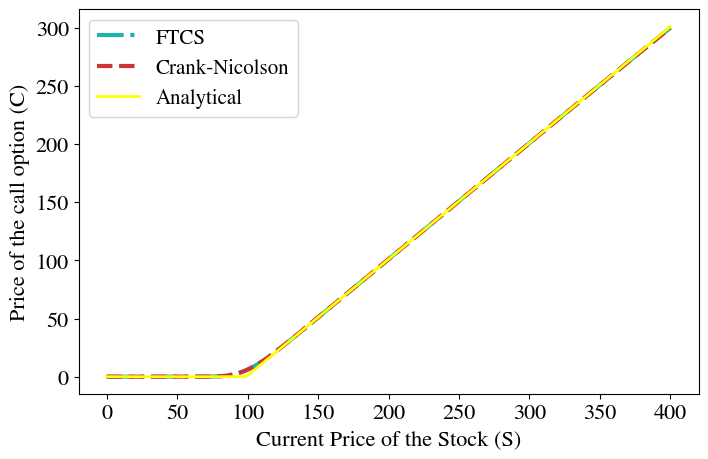

In [394]:
pyplot.figure(figsize=(8,5), dpi=100)
pyplot.plot(s, C_exp, color='#20b2aa', ls='-.', lw=3, label='FTCS');
pyplot.plot(s, C_imp, color='#cd3333', ls='--', lw=3, label='Crank-Nicolson')
pyplot.plot(s, C_exact, color='#FFFF00', ls='-', lw=2, label='Analytical')
pyplot.xlabel('Current Price of the Stock (S)')
pyplot.ylabel('Price of the call option (C)')
pyplot.legend(loc='upper left',prop={'size':15});

In [390]:
print ('FTCS:           C(S=20, t=0) = {}'.format(np.interp(S0, s, C_exp)))
print ('Crank Nicolson: C(S=20, t=0) = {}'.format(np.interp(S0, s, C_imp)))
print ('Exact Solution: C(S=20, t=0) = {}'.format(np.interp(S0, s, C_exact)))

FTCS:           C(S=20, t=0) = 7.274899459450525
Crank Nicolson: C(S=20, t=0) = 7.274547277007794
Exact Solution: C(S=20, t=0) = 2.9950333224433763


In [329]:
S0

102.0